<h1><center>Group 4</center></h1>
<h2><center>Forecasting Project</center></h2>
<h2><center>APS1017</center></h2>
<h2><center>Team Members:</center></h2>
<h3><center> Ana Caroline Teixeira Trindade Motta:  1006589979</center></h3>
<h3><center> Prabhnoor Kainth: 999066148</center></h3>
<h3><center> Venkata Krishnan Annamalai: 1006225728</center></h3>
<h3><center> Kaustubh Shinde: 1005661801</center></h3>


# Summary

The goal of this project is to forecast the demand of materials for each client in the future date based on past orders. Two methods are used, one of which is Triple exponential smoothing method (Holt-Winter’s model) and the other one is SARIMA (Seasonal Auto Regressive Integrated Moving Average) model. The former method is able to capture seasonality and trend in the observed data whereas the latter model is also able to capture non-seasonal trends with repeating patterns which are not just random noise in addition to the trend and seasonality.

These two methods is selected by investigating the order behaiviour. We notice significant sesonality in some cases as well as trends. The two selected methods work well with this type of data and can forecast without requiring any additional information.

Python code is created to import and clean the observed data from excel sheet. Plots are also created for each client, for each material and for each pair of client and material. Finally, we implement the two algorithms using existing python libraries. These libraries implement the core of the two algorithms but we implement necessary functions to perprocess the data before it can be fed to the libraries. This includes extracting just the required data from the entire dataset, finiding seasonality using autocorrelation.

A user interface is also provided to make forecasts using both methods by inputting client and or material and the forecast date.

# How to run the code

### Requirements:
   * Anaconda Python 3.5+
   * __pmdarima__ library which is not included in standard anaconda distribution.
     * This library implements the ARIMA model. This library can be installed by running *__pip install pmdarima__* 

### How to run the code
1. Place the *APS1017 Order data for Project.csv* file in the same folder as *APS1017_Group4.ipynb* notebook.
2. Run the *User Input Forecast* cell at end of this notebook to get forecast.
 

In [ ]:
# pip install pmdarima

In [ ]:
# Imports

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from matplotlib.axes import Axes as ax

# Winter's method and ARIMA model libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning

# basic python libraries
from math import sqrt
import warnings
import pandas as pd
import numpy as np
from datetime import datetime as dt
import ast
from warnings import catch_warnings, filterwarnings
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore")

## Reading in the CSV file

In [ ]:
filename = 'APS1017 Order data for Project.csv'  # This file should be in same directory as this file
df=pd.read_csv(filename)
df.head()

,Date,Client,Order Quantity,Material
0,1/27/2020,c9,11712,12293768
1,1/15/2020,c9,6895,12246740
2,1/29/2020,c4,504,12321896
3,12/18/2019,c3,189,12042081
4,12/18/2019,c3,110,11000851


***
# Data Cleansing

The following steps are performed to sanitize the data:
* Setting the *Date* column as datetime objects
* Setting *Date* column as the index to be used by the model
* Instead of dropping duplicate enteries, we assume that the client placed multiple orders on the same day. Thus we sum up all materials that the client purchased on the same day.

* Inserting the missing dates with 0 quantity orders where there was no purchasing for each pair of client and material inbetween the first and the last order date

In [ ]:
df['Date']=df['Date'].apply(pd.to_datetime)
df.sort_values(by=["Date",'Material',"Client"], inplace=True)
df=df.groupby(['Date','Client','Material'], as_index=False)['Order Quantity'].sum()
df['Date_1']=df['Date']
df.index = pd.DatetimeIndex(df.Date).to_period('D')
df=df.drop(['Date'],axis=1)
df1=df.groupby(['Client','Material']).size().reset_index().rename(columns={0:'count'})
df1.sort_values(by=["Client",'Material'], inplace=True)

merge2 = df.copy()

for i in range(len(df1)):
    client=df1.iloc[i,0]
    material=df1.iloc[i,1]
    df2 = df[(df["Client"]==client) & (df["Material"]==material)]
    df2 = df2.sort_values('Date_1')
    mindate = df2['Date_1'][0]
    maxdate = df2['Date_1'][-1]
    existing_dates = df2['Date_1']
    days = (maxdate-mindate).days
    i_dates = pd.date_range(start=mindate, end=maxdate)
    dates = []
    for d in i_dates:
        if d not in existing_dates:
            dates.append(d)
    
    df3 = pd.DataFrame({'Client': [client]*len(dates), 'Order Quantity': [0]*len(dates), 'Material':[material]*len(dates), 'Date_1':dates})
    df3.Material = df3.Material.astype(int)
    merge2 = merge2.append(df3)

merge2.index = pd.DatetimeIndex(merge2.Date_1).to_period('D')
merge2.index.name='Date'
df=merge2

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 6669 entries, 2019-12-05 to 2020-02-18
Freq: D
Data columns (total 4 columns):
Client            6669 non-null object
Date_1            6669 non-null datetime64[ns]
Material          6669 non-null int64
Order Quantity    6669 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 260.5+ KB


In [ ]:
df.head()

,Client,Date_1,Material,Order Quantity
Date,,,,
2019-12-05,c7,2019-12-05,11000851,660.0
2019-12-05,c7,2019-12-05,11000858,297.0
2019-12-05,c7,2019-12-05,11001186,504.0
2019-12-05,c7,2019-12-05,12042081,504.0
2019-12-05,c7,2019-12-05,12222902,312.0


***
# Data Visualization

### Explanation of fields:

Observed data is plotted in three contexts in different cells below; Demand of collected sum of all the materials by each client (blue plots), demand of individual material by all the clients (blue plots), and demand of each material and client pair (red plots).

### Observations in the actual data:

The demand for certain materials (e.g.: demand of materials 11000851 and 11000858 for client c8) were almost the same at the same dates, with peaks and valleys occurring at same points. This indicates that the demand of these materials are interdependent i.e., demand for one material affects the other. These could be materials that are used together. In such cases if the lead time is different for the materials, proper planning should be done before ordering as unavailability of one material affects the sale of another. Even if they have the same lead time, order must be placed in advance so that last minute delays are avoided which could negatively affect sales of both the materials. In addition to this, seasonality and trend were observed in the actual data. Some of visible observations are cited below.

**Visual observations of sum of orders placed for all materials for each client**

C1, C2, C3: Positive trend in January, Negative trend in February.

C4: No trend - Occasional surges of demand on some days (Noise).

C5:	Seasonality: Each week. Negative trend in the first half of the month. Positive trend in the second half of the month.

C6: Similar pattern at irregular interval starting mid of January. No significant seasonality present.

C8: Low demand for all the materials. No trend observed

C9: Similar but irregular pattern. Positive trend in January and negative trend in February


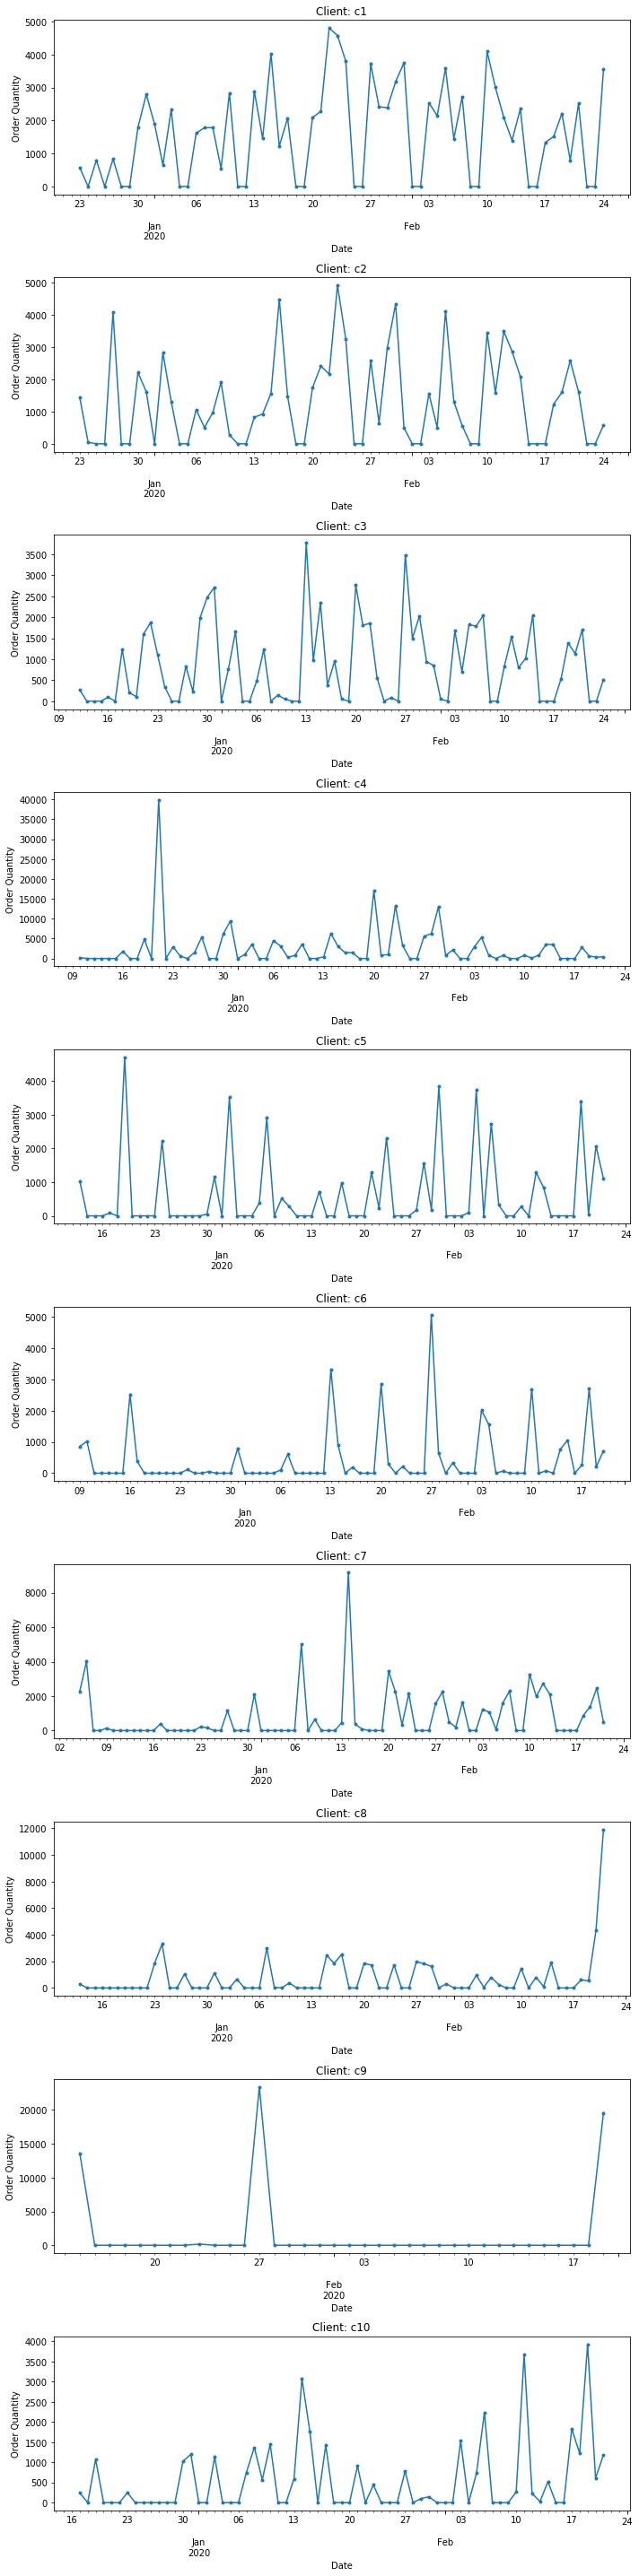

In [ ]:
# Plotting sum of all materials for each client
client_list=['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10']

fig, axs = plt.subplots(len(client_list),1,figsize=(10, 40), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(len(client_list)):
    client=client_list[i]
    df1=df[df['Client']==client]
    df1=df1.groupby(level=0)["Order Quantity"].sum()
    df1.plot(ax=axs[i],marker='.')
    axs[i].set_title("Client: {}".format(str(client)))
    axs[i].set_ylabel("Order Quantity")

plt.tight_layout()

### Sum of orders per material from all clients
**Visual observations of order placed for each material by all the clients:**

11000851, 11000858, 11001186, 12042081, 12222902, 12365978: Positive trend

12246740: Level demand with occasional surge at the middle of the month

12320618, 12320619, 12320670: Seasonality: Weekly. Increasing trend from start to end of the month. Similar pattern among the plots. Occurrence of peaks and valleys is almost the same.

12293768: Low demand with surge near the end of Jan.

12293783: Seasonality: Weekly

12160666: Low demand. Order only once a month


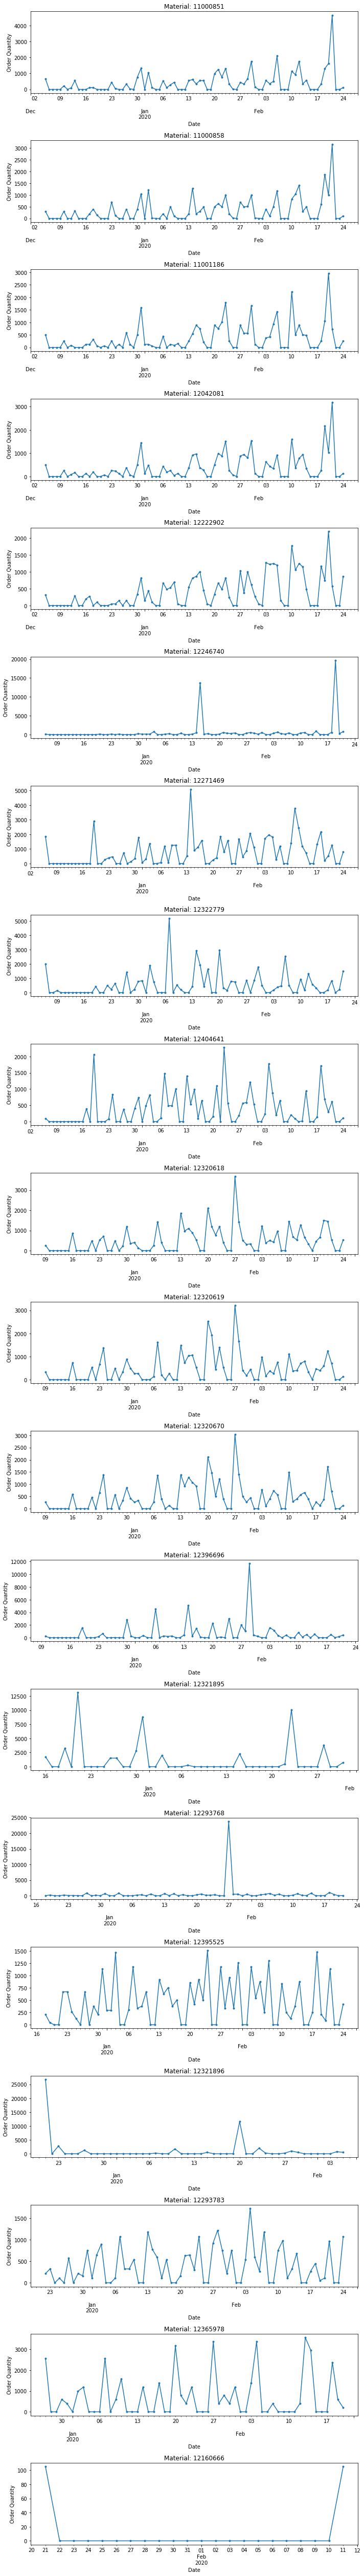

In [ ]:
# Plotting sum of order placed for each material by all the clients
material_list=df['Material'].unique()

fig, axs = plt.subplots(len(material_list),1,figsize=(10, 70), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(len(material_list)):
    material=material_list[i]
    df1=df[df['Material']==material]
    df1=df1.groupby(level=0)["Order Quantity"].sum()
    df1.plot(ax=axs[i],marker='.')
    axs[i].set_title("Material: {}".format(str(material)))
    axs[i].set_ylabel("Order Quantity")


plt.tight_layout()

### Per Client and Material

**Visual observations of order placed for each material and client pair:**

C1:	12293783, 12320618, 12320619, 12320670, 12404641: Seasonality: weekly

C2:	12293783: No seasonality and negative trend observe. 

C2:	1100051, 11001186, 1100058: Similar pattern among the plots, occurrence of peaks and valleys is almost same.

C3:	12271469, 12293783: Similar pattern among the plots, occurrence of peaks and valleys is almost same.

C4:	12365978: Seasonality: biweekly, positive trend.

C5: 12293783: Seasonality: biweekly.

C6:	12271469, 12322779:	One order in the beginning of first quarter of the year (may be for testing the reception among customers).

C7:	1240641: Seasonality - every two weeks.

C7:	12322779: Same pattern but non seasonal (ARIMA model is apt in such case).

C8:	12395525: Seasonality: every week,  no trend .

C8:	12042081: Seasonality: every two weeks,  no trend.

C8:	12404641: Seasonality: weekly. Positive trend in the 1st half of the month and negative in the 2nd half of the month (Triple exponential smoothing is apt).

C8: 12322779: Seasonality: every 9 days, Negative trend.

C8:	12320618, 12320619, 12320670: Similar pattern among the plots, occurrence of peaks and valleys is almost same.

C8:	11000851, 11000858: Similar pattern among the plots, occurrence of peaks and valleys is almost same.

C9: 12246740: One order per month.

C9:	12293768: Only one order in the beginning of the first quarter (may be for testing the reception among customers).

C10: 11000858: Seasonality: weekly.

C10: 11001186, 12222902: Similar irregular pattern, non-seasonal

__Note__: This cell could take 10-20 seconds to run

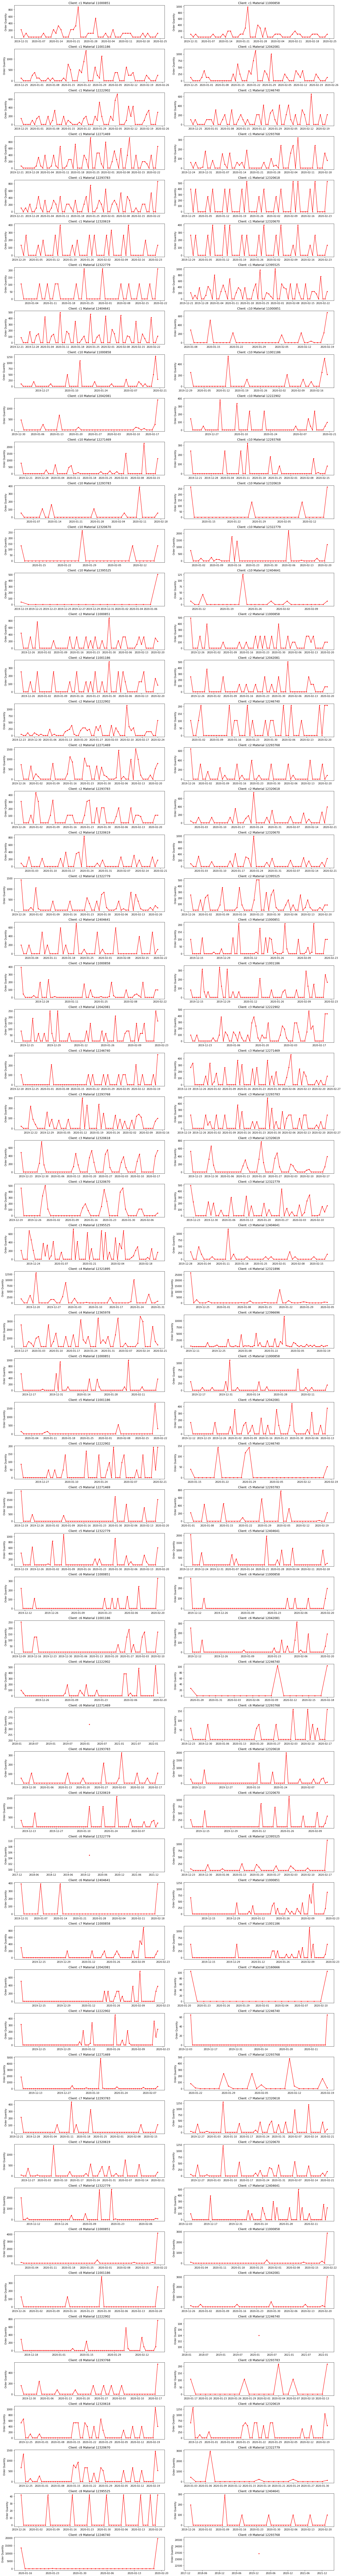

In [ ]:
# Plotting order placed for each material and client pair
df1=df.groupby(['Client','Material']).size().reset_index().rename(columns={0:'count'})
df1.sort_values(by=["Client",'Material'], inplace=True)

fig, axs = plt.subplots(59,2,figsize=(20, 150), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
merge2 = df.copy()
for i in range(len(df1)):
    client=df1.iloc[i,0]
    material=df1.iloc[i,1]    
    dfx=merge2[(merge2["Client"]==client) & (merge2["Material"]==material)].sort_values('Date_1')
    axs[i].plot(dfx['Date_1'],dfx['Order Quantity'],'.r-')
    axs[i].set_title("Client: {} Material {}".format(str(client), str(material)))
    axs[i].set_ylabel("Order Quantity")


plt.tight_layout()

***

# Methodology Explanation
In the cells below, we explain the details of each algorithm and the breakdown of the functions that implement these algorithms.

## 1. Winter's Smoothing. (Triple Exponential Smoothing) 

Triple exponential smoothing is a time series forecasting method for univariate data that can be extended to support data with a systematic trend and seasonal component.
Similar to most of the forecasting algorithms, triple exponential smoothing uses the weighted sum of the past observations but the model explicitly uses a decreasing weight for past observations.
When the data doesn’t have any trend or seasonality we use simple exponential smoothing, if the data has a trend we use double exponential smoothing and if the data is a complex combination of trend and seasonality the triple exponential smoothing or Holt –Winter's method is used.
In our specific case we have used triple exponential smoothing as it shows seasonality at different combination of material and clients.
There are three parameters involved in a time series data
1.  	A smoothing factor – Alpha
2.  	Trend  factor - Beta
3.  	Seasonality factor- Gamma

### Terminologies :

1. __Smoothing factor (Alpha)__: Alpha is that value that dictates how much weight we give the most recent observed value versus the last expected. It acts as a bias that gives more weight to the left side when it’s higher (closer to 1) or the right side when it’s lower (closer to 0) Thus alpha can be called as a memory decay rate i.e. higher the decay rate, the faster the method forgets. Usually the value ranges from 0.1 to 0.3.
2. __Trend__: Trend defines the slope which the data follows over the period of time.
3. __Trend factor (Beta)__: Beta is the constant used for smoothing of the trend. Usually the value ranges from 0.1 to 0.3. Similar to smoothing factor Alpha as the value increases the weight of the most recent observations increases.
4. __Seasonality__: If a series appears to be repetitive at regular intervals, such an interval is referred to as a season, and the series is said to be seasonal. Seasonality is required for the Holt-Winters method to work, non-seasonal series (e.g. stock prices) cannot be forecasted using this method (would be nice though if they could be).
5. __Seasonal Length__: Seasonal length is the number of data points after which new season begins.
6. __Seasonal smoothing factor (Gamma)__: Gamma is used to smoothen the seasonal data. Similar to other smoothing factors the value of Gamma usually lies between 0.1 and 0.3  and higher value provides higher weightage to recent observations.
 
The idea behind triple exponential smoothing is to apply exponential smoothing to the seasonal components in addition to level and trend. The smoothing is applied across seasons, e.g. the seasonal component of the 3rd point into the season would be exponentially smoothed with the one from the 3rd point of last season, 3rd point two seasons ago, etc. In math notation we now have the following four equations:


\begin{align} l_x &= \alpha (y_x−s_x−L) + (1−\alpha) (l_{x−1} + b_{x−1}) \tag{ level } \end{align}	      	
\begin{align} b_x  &= \beta (l_x−l_{x−1})+(1−\beta)b_{x−1}  \tag{ trend } \end{align}  	                      
\begin{align} s_x &=\gamma (y_x−l_x)+(1−\gamma)s_{x−L} \tag{ seasonal } \end{align}   	                   	
\begin{align} \hat{y}_{x+m} &= l_{x}+mb_{x}+s_{x−L+1+(m−1)modL} \tag{ forecast } \end{align}        	


To compute the optimal values of alpha, beta and gamma, the loop is run with all possible combinations and the combination with the least sum of squared estimate errors (SSE) is selected. Basically, fitting is done to get the best estimation.

## 2. SARIMA  (Seasonal AutoRegressive Integrated Moving Average)
SARIMA is a generalization of seasonal auto regressive moving average which adds a notion of integration. SARIMA uses only the previous values for predicting the future values and hence it is a type of *Univariate Time Series* forecasting.
There are three key aspects of the model which are:
1. **Auto Regressive (AR)**: This term depends on the relation between an observation and the lagging observation.
2. **Integrated **: Converting the time series into a stationary series by differencing current raw observation from the previous observation.
3. **Moving Average (MA)**: A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

While building the basic non seasonal model (ARIMA), the performance is dependent on 3 terms *p,q and d*.
* p: Term representing auto regressive part. It is the number of lag observations included in the model, also called as the lag order.
* d: Term representing integrated part. It is the number of times that the raw observations are differenced, also called the degree of differencing.
* q: Term representing moving average part. It is the size of the moving average window, also called the order of moving average.

#### Computation of differencing term (d)
As we need to perform linear regression over the data set, we need to make the series stationary i.e to remove the part which has trend and seasonality so that it doesn’t affect the result of the regression model. The seasonality and trend is removed by differencing the data set and it is governed by the parameter d in the model. Differencing is basically subtracting the current value from the previous value so that the observations do not have any correlation between them when the linear regression is performed. Differencing can be done multiple times so as to get a suitable dataset to perform regression, i.e. if d = 1 then differencing is done once and if d = 2 differencing is done twice. In case there is no seasonality or trend and the data is already stationary, differencing can be avoided completely by setting the value of d to 0. The autocorrelation is the deciding factor for the differencing value, if the autocorrelation is too positive for higher lag value (lag = 10) then further differencing is required while if the autocorrelation is too negative the series is over differenced. The stationarity of the series is checked using the *Augmented Dickey Fuller* test which is explained later in the function explanation section.  

#### Autoregressive model and computation of AR term (p)
The prediction depends on the lags and can be statistically represented by the equation below. The p term here is number of the previous predictions to take into consideration for computation.

\begin{align} y_t &= \delta + \phi_1 y_{t-1} + \phi_2 y_{t-2} + … + \phi_p y_{t-p} + A_{t} \end{align}
$$ A_t: \text{ white noise, i.e. randomness} $$
$$ y_{t-1}, y{t-2} ...y_{t-p}  \text{: the past series values (lags)}$$

The term p is computed by inspecting the *Partial autocorrelation plots (PACF)*. The PACF plot provides pure correlation between the series and its lag. To compute p we assign a its value to be equal to the number of lags that crosses the significance limit in the PACF plot.

#### Moving Average Model and computation of MA term (q)
The prediction depends on moving average and can be statistically represented by the equation below. The q term here represent the order of moving average.

\begin{align}  y_t &= c+ \epsilon_t+ \theta_1 \epsilon_{t−1}+ \theta_2 \epsilon_{t−2} +⋯+ \theta_q \epsilon_{t−q} \end{align}
$$ \epsilon_t: \text{white noise} $$
$$ \epsilon_{t−n}: \text{error terms} $$


Similar to the AR term (p), the value of the MA term (q) is computed using the ACF plot. MA term is the error of the lagged forecast. ACF will provide us with the number of terms required to remove autocorrelation in the stationarized series.
Note: In our current machine learning model we have used the automated model to compute the p, q and d and the best combination is found using AIC *(Akaike Information Criteria)*.

### Addition of seasonal component to ARIMA
The above steps are common for non-seasonal as well as seasonal time series data. However for seasonal data, the differencing is done not by subtracting the current value from the previous observation but by subtracting the value from the previous season. Due to seasonal time series data we introduce 4 new terms to the model
* m: Term representing seasonality. This term specifies the periodicity in the data. This is calculated using the autocorellation method as explained above
* P: Term representing seasonal auto regressive part
* Q: Term representing seasonal moving average part
* D: Term representing the seasonal differencing

Thus the final model for SARIMA will be represented as *SARIMA[p,d,q]x[P,D,Q]*  where ‘x’ is the frequency of time series 


#  Explanations for Major Functions

## Subroutines common to both methods
In both SARIMA and Triple Exponential Smoothing, two conditions need to be satisfied before the forecast is calculated. These are: First, combinations of client and materials with only one data point cannot not be used to forecast. Second, the date to be forecasted needs to be later than the last date in the dataset. When one of these conditions is not satisfied the user is informed.

### Function: get_corresponding_data()
The **get_corresponding_data()** function is implemented to define the data set to be used in the model. In this way, the following conditions is defined. Firstly, if only the client is selected, the dataset is filtered by the client, then it is grouped by date and the order quantity is aggregated for each material at that day. The same is done when selecting only material, but in this case the dataset is filtered to show only the material selected. In case both client and material are selected, the dataset is filtered using these two conditions and the order quantity is aggregated for each date. If there is no combination of client and material in the dataset, the function returns a message informing the user. Finally, if neither client nor material is selected, the function returns a message informing the user should select client or material in order to continue.
 
### Function: plot_data()
The **plot_data()** function is created to illustrate the model result. It plots the actual data, the model predictions over the entire period and the forecasted data for the particular date requested by the user.


In [ ]:
def get_corresponding_data (df, client="NA", material="NA"):
    #verifying if at least one client or one material was selected
    
    if client != "NA":
        if client not in client_list:
            print("ERROR - Client {} does not exist".format(client))
            return -1
    if material != "NA":
        if material not in material_list:
            print("ERROR - Material {} does not exist".format(material))
            return -1
        
    if client== "NA" and material =="NA":
        return print("Please select a client or a material in order to continue.")
    #if material was selected, filter dataset
    if client=="NA":
        df_forecast=df[df["Material"]==material]
        df_forecast=df_forecast.groupby(level=0)["Order Quantity"].sum()
        return df_forecast
    #if client was selected, filter dataset
    if material=="NA":
        df_forecast=df[df["Client"]==client]
        df_forecast=df_forecast.groupby(level=0)["Order Quantity"].sum()
        return df_forecast
    #if both client and material were selected, filter data set
    else:           

        try:
            df_forecast=df[(df["Client"]==client) & (df["Material"]==material)]
            df_forecast=df_forecast.groupby(level=0)["Order Quantity"].sum()
            if df_forecast.shape[0] == 0:
                a = 1/0
            return df_forecast
        #if the client does no purchase the material selected, return a error 
        except:
            print("ERROR - Client ", client, " does not purchase ",material)
            return -1
            
def plot_data(x, forecasts, actual, date, final_forecast, method):
    fig=plt.figure(figsize=(15, 6))
    plt.xticks(rotation=90)
    plt.title('{} {}, {}'.format(method, client, material))
    plt.plot(actual.index.to_timestamp(), actual, c='blue', marker='.', label='Actual Data')

    plt.plot(x, forecasts, c='green', marker='x', label='Forcasted Data')
    plt.plot(date, final_forecast,'ro', label = 'Forecast') 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=[MO, WE, FR]))
    plt.legend()
    plt.show()

### Function: find_periodicity()

The function **find_periodicity()**, is used to find periodicity in the data. We find periodicity/seasonality by performing autocorrelation which finds any repeating patterns in the data. We select the periodicity with the highest autocorrelation as the seasonality if and only if it is > 0.3. If none of the periods have autocorrelation > 0.3, we assume that there is no seasonality in the data. [1]

In [ ]:
def find_periodicity(data):
    # finding periodicty
    cor_list = []
    for l in range(2, 15):
        coor = data.autocorr(lag=l)
        cor_list.append(coor)
    if np.max(cor_list) > 0.3:
        # found it
        m  = np.argmax(cor_list)+2 
        autocor = np.max(cor_list)
    else:
        m = -1
        autocor = -1
    return (autocor, m)
    

### Example of autocorrelation to find seasonality 
As shown below, client c1 and material 11001186 combination shows high seasonality with big orders being placed almost once a week. This can be seen in the orders vs time plot and also in the autocorrelation plot below as a peak at period = 7.

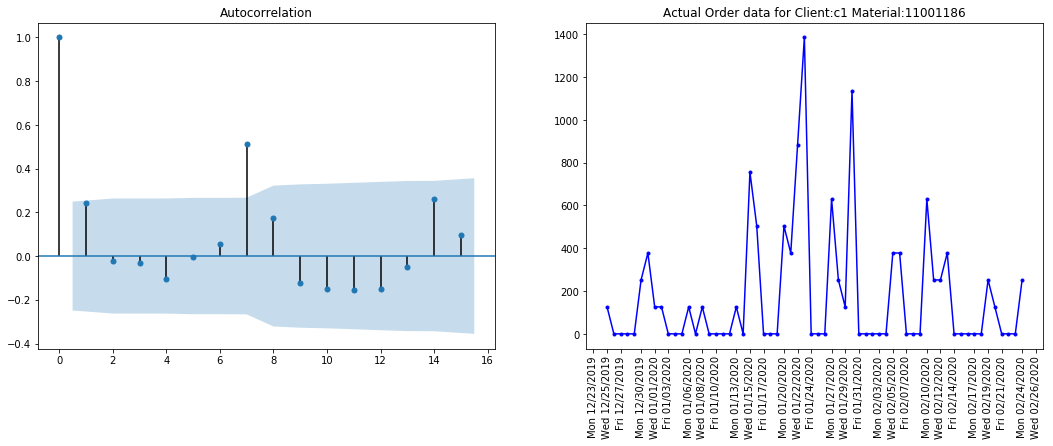

In [ ]:

data = get_corresponding_data(df ,'c1', 11001186)
fig,(ax0, ax1) = plt.subplots(1,2, figsize=(18, 6))
x = pd.date_range(data.index.to_timestamp()[0],data.index.to_timestamp()[-1]).tolist()
plt.xticks(rotation=90)
plt.plot(x, data, c='blue', marker='.', label='Actual Data')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=[MO, WE, FR]))
plt.title("Actual Order data for Client:{} Material:{}".format('c1', 11001186))

tsaplots.plot_acf(data, lags=15, ax=ax0);

## Functions used for Triple Exponential Smoothing
### Function:  forecast_winters_smoothing()

The methodology used in implementation of the **forecast_winters_smoothing()** function is based on [2].
In this approach, the Holt-Winters Exponential Smoothing provided by the statsmodels library is the model used to forecast the time series [3]. The Holt-Winters method has two advantages. First, it supports both trend and seasonally. Second, it can automatically optimize the hyperparameters alpha, beta and gamma by setting the ‘optimized’ component equal to true. These two functionalities are employed in this project.

In order to define if there is a trend component in the data, we implemented walking-forward validation and grid search functions. The walking-forward validation is the most common methodology used to evaluate a forecasting model with a time-based series. First, **walk_forward_validation()** function divides the dataset in train and test, using the function **train_test_split_1()**. In the code implemented, the training dataset is composed of the first 66.6% data values while the test dataset is composed of the 33.4% final values. Then, by using a one-step forecast and of the train dataset, the value for the next day is predicted. Next, the true observation for the following day is added to the training dataset and a new forecast is calculated. This process is repeated until the training dataset has the same data values as the original dataset. Finally, by using the **measure_rmse()** function, an error score is calculated using the forecasted values and the testing dataset. The score used in this project was the root mean squared error (RMSE).

The **grid_search()** function calculates the error of the model when the ‘trend’ parameter is set to None and when it is set to ‘add’. Finally, the model that generated the lowest score error is selected by the function.
With regards to the seasonality component, the ‘seasonal’ and ‘seasonal_periods’ parameters were defined using the **find_periodicity()** function described above.

The function also prints the calculated parameters used by the model.

In [ ]:
# grid search holt winter's exponential smoothing
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split_1(data, n_test):
    return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split_1(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
    # one failure during model validation suggests an unstable config
        try:
        # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    return (key, result)
 
#grid search configs
def grid_search(data, cfg_list, n_test, parallel=False):
    scores = None
    scores = []
    i = 0
    for cfg in cfg_list:
        i+=1
        print("Evaluating configuration {} / {} configurations...".format(i, len(cfg_list)))
        scores.append(score_model(data, n_test, cfg))
            
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores
 
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None], s_params=[None]):
    models = list()
    # define config lists
    t_params = ['add',None]
    d_params = [False]
    s_params = s_params
    p_params = seasonal
    b_params = [False]
    r_params = [True]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models


            
def forecast_winters_smoothing(dataframe, date, client="NA", material="NA"):
        #filtering data set by client and material
    data=get_corresponding_data(dataframe,client,material)
    if type(data) == int:  # invalid client/material
        return
        # evaluating if there is enough datapoint to make a forecast
    if len(data)==1:
        return print('It was not possible to forecast this combination of client and material because it has only one data point.')
        # setting the right format for the date
    date=dt.strptime(date,'%Y-%m-%d')
        #defining how many steps the model will take
    n=date-data.index.to_timestamp()[-1]
    n_periods=n.days
        # retuning a message asking to select a date after the period.
    if n_periods<=0:
        return print('Select a date after: ',data.index.to_timestamp()[-1])
        # defining the dataset to be used in the gridsearch, if the there is less than 3 data points, use only one data.
    if len(data)<3:
        n_test=1
    else:
#         using 33.33% of the data in the gridsearch
        n_test = int(len(data)/3)
    
    ############ FINDING PERIODICITY
    (autocor, m) = find_periodicity(data)

    if autocor == -1: # no seasonality
        s_params = None
        seasonal = None
    else:
        s_params = 'add'
        seasonal = m
        
    ############ DONE FINDING PERIODICITY
        # creating a list of parameters to be evaluated
    cfg_list = exp_smoothing_configs([seasonal], [s_params])
        # calculating the score for each set of parameters
    scores = grid_search(data, cfg_list, n_test)
        # getting the parameter with the lowest score - lowest error
    parameters=ast.literal_eval(scores[0][0])
    t,d,s,p,b,r = parameters

    # defining a model
    model = ExponentialSmoothing(data, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        #fitting a model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # making multiple steps forecast
    yhat = model_fit.predict(date, date)
    if yhat[date] < 0:
        yhat[date] = 0
    forecast = model_fit.predict(start=data.index.to_timestamp()[0],end=date)
    
        # Showing the forecast and the parameters used.
    print ('-------------------------------------------------')
    print ("*Prediction on {} is {:.1f}*".format(date.date(), yhat[date]))
    print ('-------------------------------------------------')
    
    print ('---Properties of Order Quantity---')
    if parameters[0] is not None:
        print("Trend found in data.")
    if seasonal is not None:
        print("Seasonality found based on autocorrelation in data with period of {} days and autocorrelation value of {}". format(seasonal, autocor))
    else:
        print ("None or insignificant seasonality found in data.")
    print ('---------------------------------')

        # plotting the data and forecast point.
    x = pd.date_range(data.index.to_timestamp()[0], date).tolist()
    plot_data(x, forecast, data, date, yhat, "Triple Exponential Method")
       

### Functions used for SARIMA

#### Function: forecast_SARIMA()
The model used to implement the SARIMA methodology is called ‘auto_arima’ and it is retrieved from the pyramid library [4]. This model has a great advantage of automatically calculating the best parameters. This process is done by calculating the *AIC (Akaike Information Criteria)* for each combination of parameters and by selecting the model with the lowest AIC. [5]
The following parameters are set up in the ‘auto_arima’ model:
* start_p / max_p: range to be used in the grid search regarding the order of the auto-regressive (AR) model.
* start_q / max_q: range to be used in the grid search regarding the order of the moving average (MA) model.
* test = ‘adf’: using the *Augmented Dickey Fuller* test to define the optimal degree of differencing value. 
* d = None: initializing the degree of differencing.

For this method, the seasonal parameters, m and D, are selected based on **find_periodicity()** function described above.

This function also prints the calculated parameters used by the model.

In [ ]:
def forecast_SARIMA (df, date ,client='NA',material='NA'):
        #filtering data set by client and material
    data=get_corresponding_data(df ,client,material)
    if type(data) == int: # invalid client/material
        return 
        # evaluating if there is enough datapoint to make a forecast
    if len(data)==1:
        return print('It was not possible to forecast this combination of client and material because it has only one data point.')
        # setting the right format for the date
    date=dt.strptime(date,'%Y-%m-%d')
        #defining how many steps the model will take
    n=date-data.index.to_timestamp()[-1]
    n_periods=n.days
        
    #defining seasonality based on the charts.
        # retuning a message asking to select a date after the period.
    if n_periods<=0:
        return print('Select a date after: ',data.index.to_timestamp()[-1])
    

    (autocor, m) = find_periodicity(data)
    if autocor == -1: # no seasonality
        D = 0
        m = 1
        seasonal = False
    else:
        D = 1
        seasonal = True
 
        
    smodel = pm.auto_arima(data, 
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=5, 
                           max_q=5, 
                           m=m, #weekly
                           start_P=0, 
                           seasonal=seasonal,
                           d=None, 
                           D=D, 
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)

    fitted= smodel.predict(n_periods=n_periods)
    
    forecasts_past = smodel.predict_in_sample(start = 1, end = data.shape[0]-1)
    forecasts = np.append(forecasts_past, fitted)
    

    yhat = fitted[-1]
    if yhat < 0:
        yhat = 0
#             Showing the forecast and the parameters used.
    print ('-------------------------------------------------')
    print ("*Prediction on {} is {:.1f}*".format(date.date(), yhat))
    print ('-------------------------------------------------')
    
    if seasonal is True:
        print("Seasonality found based on autocorrelation in data with period of {} days and autocorrelation value of {}". format(m, autocor))
    else:
        print ("None or insignificant seasonality found in data.")
    print ('---------------------------------')
    print ('---ARIMA Parameters---')
    print('p =',smodel.order[0],' - Order of the auto-regressive (AR)')
    print('d =',smodel.order[1],' - Degree of Differencing')
    print('q =',smodel.order[2],' - Order of the moving average (MA)')
    print('P =',smodel.seasonal_order[0],' - Order of the seasonal component for the auto-regressive (AR)')
    print('D =',smodel.seasonal_order[1],' - Integration order of the seasonal process')
    print('Q =',smodel.seasonal_order[2],' - Order of the seasonal component of the moving average (MA)')
    print('m =',smodel.seasonal_order[3],' - Seasonality period')
    print ('----------------------------------')



        # plotting the data and forecast point.
    x = pd.date_range(data.index.to_timestamp()[1], date).tolist()
    plot_data(x, forecasts, data, date, fitted[-1], "ARIMA Method")
    

***
# User Input Forecast
Run the cell below to get prediction for one of the 3 cases:
1. Client and Material on a particular date.
2. Orders for all materials for a particular client on a particular date. [Material = NA]
3. Orders from all clients for a particular material on a particular date [Client = NA]

### Steps to get a forecast:
1. Run the cell
2. Enter client and/or material and date in the prompt. Leave empty or NA if no client or material is to be specified.
3. The model are created, fitted and evaluated and the results are displayed

### Result:
The forecasts for both ARIMA and Triple Exponential Smoothing are printed along with the parameters used to create the models.
In addition, plots with actual data, predicted data and the final prediction are plotted for both of the methods.

The X axis in the plots corresponds to the date and Y axis to the order quantity. 

**Note**: Since the models do not discriminate against negative values, predicted amount can be less than 0. Since in this case, order amount less than 0 is meaningless, we limit the minium predicted output to 0.  

Enter Client or NA: c1
Enter Material or NA: 12404641
Enter Date (yyyy-mm-dd): 2020-03-03

Starting ARIMA ...
-------------------------------------------------
*Prediction on 2020-03-03 is 122.7*
-------------------------------------------------
Seasonality found based on autocorrelation in data with period of 7 days and autocorrelation value of 0.9171575392585235
---------------------------------
---ARIMA Parameters---
p = 0  - Order of the auto-regressive (AR)
d = 0  - Degree of Differencing
q = 0  - Order of the moving average (MA)
P = 0  - Order of the seasonal component for the auto-regressive (AR)
D = 1  - Integration order of the seasonal process
Q = 1  - Order of the seasonal component of the moving average (MA)
m = 7  - Seasonality period
----------------------------------


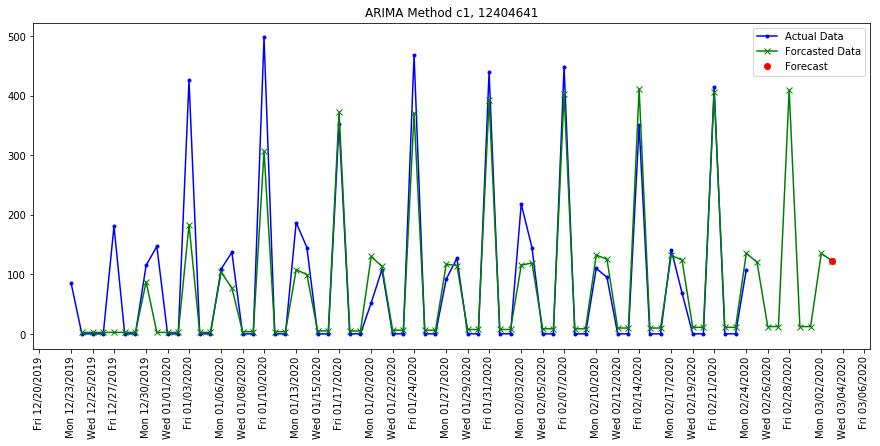


Starting Triple Exponential Smoothing ...

Evaluating configuration 1 / 2 configurations...
Evaluating configuration 2 / 2 configurations...
-------------------------------------------------
*Prediction on 2020-03-03 is 110.4*
-------------------------------------------------
---Properties of Order Quantity---
Seasonality found based on autocorrelation in data with period of 7 days and autocorrelation value of 0.9171575392585235
---------------------------------


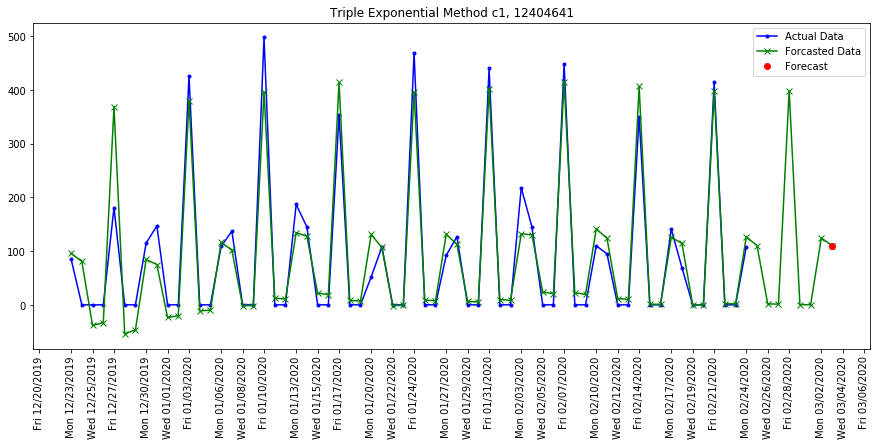

In [ ]:
ok = False

# Prompt with some error checking
while not ok:
    client =input("Enter Client or NA: ").lower()
    if client == "":
        client = "NA"

    material = input("Enter Material or NA: ")
    if material == "":
        material = "NA"

    if material.upper() == "NA" and client.upper() == "NA":
        print("Both Client and Material cannot be NA. Please enter atleast a client or a manterial")
        ok = False
        continue
    else:
        ok = True

    if material.upper() != "NA":
        material = int(material)
     
    dateok = False
    while not dateok:
        try:
            date = input("Enter Date (yyyy-mm-dd): ")
            testdate = dt.strptime(date, '%Y-%m-%d')
        except:
            print("Not a valid date. Please try again.")
            dateok = False
        else:
            dateok = True
            
#### Running the Forecast ####
print('\nStarting ARIMA ...')
forecast_SARIMA (df,  client = client, date=date, material=material)
print('\nStarting Triple Exponential Smoothing ...\n')
forecast_winters_smoothing(df, date, material=material, client=client)


# References

[1] https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html

[2] https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

[3] https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

[4] https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima

[5] https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/